In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# Federated learning hyperparameters
num_epochs, learning_rate = 5, 0.001
batch_sizes, communication_rounds = [64, 128], 100

In [3]:
# Define a deep learning model (CNN)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Modify the architecture based on your requirements
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [4]:
# Dataset preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Assuming you have the FEMNIST dataset downloaded and split for each client
# Replace 'path_to_client_data' with the actual path to the client data
client_dataset = torchvision.datasets.FashionMNIST(root='path_to_client_data', train=True, download=True, transform=transform)

# Split the client dataset into train and validation sets
train_size = int(0.8 * len(client_dataset))
val_size = len(client_dataset) - train_size
client_train_set, client_val_set = random_split(client_dataset, [train_size, val_size])

# DataLoader for training and validation
train_loaders = [DataLoader(client_train_set, batch_size=batch_size, shuffle=True, num_workers=4) for batch_size in batch_sizes]
val_loader = DataLoader(client_val_set, batch_size=batch_sizes[0], shuffle=False, num_workers=4)

100%|██████████| 26421880/26421880 [00:01<00:00, 16054487.36it/s]


Extracting path_to_client_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to path_to_client_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 257529.37it/s]


Extracting path_to_client_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to path_to_client_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4993353.04it/s]


Extracting path_to_client_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to path_to_client_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21965693.79it/s]


Extracting path_to_client_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to path_to_client_data/FashionMNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
# Function to train the model for a given federated learning algorithm
def train_federated_learning(model, train_loader, algorithm_name):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    performance_metrics = {'accuracy': [], 'loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - {algorithm_name}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss at the end of each epoch
        average_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Loss: {average_loss:.4f}')

        # Evaluate on validation set
        accuracy = evaluate_model(model, val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Validation Accuracy: {accuracy * 100:.2f}%')

        performance_metrics['accuracy'].append(accuracy)
        performance_metrics['loss'].append(average_loss)

    return performance_metrics

# Function to evaluate the model on the validation set
def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [6]:
# Train & Evaluate FedAvg
fedavg_model = CNNModel().to(device)
fedavg_performance = train_federated_learning(fedavg_model, train_loaders[0], 'FedAvg')

# Train & Evaluate FedProx
fedprox_model = CNNModel().to(device)
fedprox_performance = train_federated_learning(fedprox_model, train_loaders[0], 'FedProx')

# Train & Evaluate FedShare
fedshare_model = CNNModel().to(device)
fedshare_performance = train_federated_learning(fedshare_model, train_loaders[0], 'FedShare')

# Train & Evaluate FedMeta w/ UGA
fedmeta_uga_model = CNNModel().to(device)
fedmeta_uga_performance = train_federated_learning(fedmeta_uga_model, train_loaders[0], 'FedMeta w/ UGA')

Epoch 1/5 - FedAvg: 100%|██████████| 750/750 [00:21<00:00, 35.67it/s]

Epoch [1/5] - FedAvg, Loss: 0.4276


Epoch [1/5] - FedAvg, Validation Accuracy: 88.19%


Epoch 2/5 - FedAvg: 100%|██████████| 750/750 [00:12<00:00, 60.67it/s]

Epoch [2/5] - FedAvg, Loss: 0.2652


Epoch [2/5] - FedAvg, Validation Accuracy: 90.51%


Epoch 3/5 - FedAvg: 100%|██████████| 750/750 [00:12<00:00, 58.77it/s]

Epoch [3/5] - FedAvg, Loss: 0.2159


Epoch [3/5] - FedAvg, Validation Accuracy: 91.53%


Epoch 4/5 - FedAvg: 100%|██████████| 750/750 [00:12<00:00, 57.86it/s]

Epoch [4/5] - FedAvg, Loss: 0.1784


Epoch [4/5] - FedAvg, Validation Accuracy: 91.70%


Epoch 5/5 - FedAvg: 100%|██████████| 750/750 [00:13<00:00, 57.46it/s]

Epoch [5/5] - FedAvg, Loss: 0.1486


Epoch [5/5] - FedAvg, Validation Accuracy: 92.29%


Epoch 1/5 - FedProx: 100%|██████████| 750/750 [00:13<00:00, 54.10it/s]

Epoch [1/5] - FedProx, Loss: 0.4213


Epoch [1/5] - FedProx, Validation Accuracy: 89.07%


Epoch 2/5 - FedProx: 100%|██████████| 750/750 [00:13<00:00, 56.34it/s]

Epoch [2/5] - FedProx, Loss: 0.2664


Epoch [2/5] - FedProx, Validation Accuracy: 90.76%


Epoch 3/5 - FedProx: 100%|██████████| 750/750 [00:15<00:00, 49.00it/s]

Epoch [3/5] - FedProx, Loss: 0.2133


Epoch [3/5] - FedProx, Validation Accuracy: 90.66%


Epoch 4/5 - FedProx: 100%|██████████| 750/750 [00:12<00:00, 59.02it/s]

Epoch [4/5] - FedProx, Loss: 0.1785


Epoch [4/5] - FedProx, Validation Accuracy: 91.83%


Epoch 5/5 - FedProx: 100%|██████████| 750/750 [00:13<00:00, 57.27it/s]

Epoch [5/5] - FedProx, Loss: 0.1459


Epoch [5/5] - FedProx, Validation Accuracy: 90.99%


Epoch 1/5 - FedShare: 100%|██████████| 750/750 [00:13<00:00, 57.32it/s]

Epoch [1/5] - FedShare, Loss: 0.4289


Epoch [1/5] - FedShare, Validation Accuracy: 88.90%


Epoch 2/5 - FedShare: 100%|██████████| 750/750 [00:13<00:00, 55.45it/s]

Epoch [2/5] - FedShare, Loss: 0.2725


Epoch [2/5] - FedShare, Validation Accuracy: 89.78%


Epoch 3/5 - FedShare: 100%|██████████| 750/750 [00:13<00:00, 55.73it/s]

Epoch [3/5] - FedShare, Loss: 0.2206


Epoch [3/5] - FedShare, Validation Accuracy: 90.76%


Epoch 4/5 - FedShare: 100%|██████████| 750/750 [00:13<00:00, 57.23it/s]

Epoch [4/5] - FedShare, Loss: 0.1867


Epoch [4/5] - FedShare, Validation Accuracy: 91.74%


Epoch 5/5 - FedShare: 100%|██████████| 750/750 [00:12<00:00, 58.35it/s]

Epoch [5/5] - FedShare, Loss: 0.1549


Epoch [5/5] - FedShare, Validation Accuracy: 91.78%


Epoch 1/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:12<00:00, 60.72it/s]

Epoch [1/5] - FedMeta w/ UGA, Loss: 0.4300


Epoch [1/5] - FedMeta w/ UGA, Validation Accuracy: 89.53%


Epoch 2/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:12<00:00, 59.79it/s]

Epoch [2/5] - FedMeta w/ UGA, Loss: 0.2740


Epoch [2/5] - FedMeta w/ UGA, Validation Accuracy: 90.45%


Epoch 3/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 57.00it/s]

Epoch [3/5] - FedMeta w/ UGA, Loss: 0.2230


Epoch [3/5] - FedMeta w/ UGA, Validation Accuracy: 90.88%


Epoch 4/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 56.17it/s]

Epoch [4/5] - FedMeta w/ UGA, Loss: 0.1859


Epoch [4/5] - FedMeta w/ UGA, Validation Accuracy: 91.92%


Epoch 5/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 56.89it/s]

Epoch [5/5] - FedMeta w/ UGA, Loss: 0.1541


Epoch [5/5] - FedMeta w/ UGA, Validation Accuracy: 92.07%


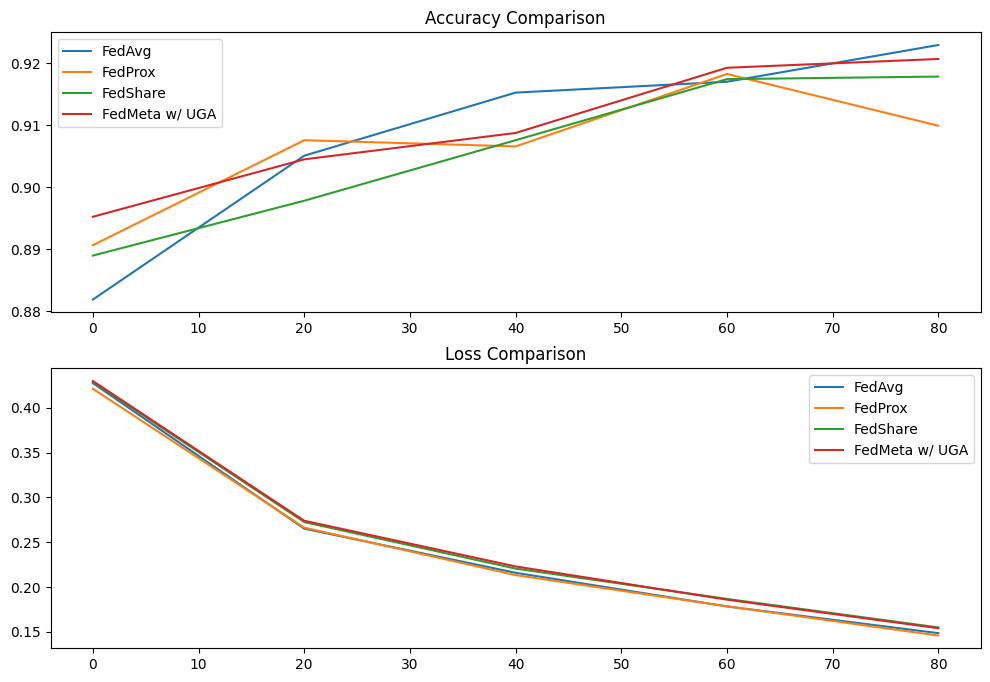

In [7]:
# Create comparison plots for FEMNIST
plt.figure(figsize=(12, 8))

# Test accuracy comparison
plt.subplot(2, 1, 1)
plt.title("Accuracy Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedavg_performance['accuracy'], label='FedAvg')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedprox_performance['accuracy'], label='FedProx')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedshare_performance['accuracy'], label='FedShare')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance['accuracy'], label='FedMeta w/ UGA')

# Loss comparison
plt.subplot(2, 1, 2)
plt.title("Loss Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedavg_performance['loss'], label='FedAvg')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedprox_performance['loss'], label='FedProx')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedshare_performance['loss'], label='FedShare')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance['loss'], label='FedMeta w/ UGA')

plt.show()